# Base Leaners - Grid Search (with Manual Feature Selection)

Performing grid search on base learners to find best parameters for each base learner

In [1]:
# import libraries
import warnings
import pandas as pd
import numpy as np

warnings.filterwarnings(action='ignore')

# import custom class
from tadpole import Tadpole

# base learners
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# metrics
from sklearn.metrics import balanced_accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix, make_scorer

# import visualization library
from matplotlib import pyplot as plt
import seaborn as sns


# set seed (for reproducibility)
np.random.seed(43)

%matplotlib inline
sns.set(style='whitegrid', palette="deep", font_scale=0.7, rc={"figure.figsize": [8, 5]})

### Data Loading + Pre-processing

In [2]:
# load and pre-process tadpole dataset
tp = Tadpole(debug=True, isCorr=True)
print("Labels:", tp.label_dict)

loading tadpole dataset
pre-processing dataset
Labels: {0: 'AD', 1: 'CN', 2: 'MCI'}


In [3]:
# train-test split
X_train, X_test, y_train, y_test = tp.split()

splitting dataset to train and test datasets


In [4]:
# import variables from class instance (notebook compatibility)
X, y, label_dict = tp.X, tp.y, tp.label_dict

In [5]:
# define scoring parameter
scoring = {'BA': make_scorer(balanced_accuracy_score)}

Helper Functions

In [6]:
def showConfusionMatrix(clf, X, y):
    cm = confusion_matrix(y, clf.predict(X))
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm, cmap='GnBu')
    ax.grid(False)

    # For 3 categories
    ax.xaxis.set(ticks=(0, 1, 2), ticklabels=('Predicted ' + label_dict[0], 'Predicted ' + label_dict[1], 
                                              'Predicted ' + label_dict[2]))
    ax.yaxis.set(ticks=(0, 1, 2), ticklabels=('Actual ' + label_dict[0], 'Actual ' + label_dict[1], 
                                              'Actual ' + label_dict[2]))

    for i in range(3):
        for j in range(3):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='black')
    plt.title('Test Data Confusion Matrix')
    plt.show()
    
def computeMetrics(model, X, y):
    """
    @description:
        function to compute performance metrics
    @arguments:
        model (sklearn) - trained model
        X (np.array) - features
        y (np.array) - target
    """
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)
    BCA = balanced_accuracy_score(y, y_pred)
    mAUC = roc_auc_score(y, y_prob, multi_class="ovr", average="macro")
    return BCA, mAUC

def report(model):
    """
    @description:
        function to report trained model performance
    @arguments:
        model (sklearn) - trained model
    """
    score_train = model.score(X_train, y_train)
    score_test = model.score(X_test, y_test)
    BCA_train, mAUC_train = computeMetrics(model, X_train, y_train)
    BCA_test, mAUC_test = computeMetrics(model, X_test, y_test)
    print("========Model Evaluation Report========")
    print("Train Score: ", score_train)
    print("Test Score: ", score_test)
    print("=======================================")
    print("Train BCA: {:.3f} | Train AUC: {:.3f}".format(BCA_train, mAUC_train))
    print("Test BCA: {:.3f} | Test AUC: {:.3f}".format(BCA_test, mAUC_test))
    print("=======================================")
    showConfusionMatrix(model, X_test, y_test)
    return [score_train, score_test, BCA_train, BCA_test, mAUC_train, mAUC_test]

def evaluate(baselearners):
    """
    @description:
        function to evaluate base learners
    @arguments:
        baselearners (sklearn) - list of trained models
    """
    metrics = []
    for name, model in baselearners.items():
        print(name)
        results = report(model)
        metrics.append([name] + results)
    return metrics

### Grid Search: Model Training

In [7]:
# define search grids
lra_param_grid = {'penalty'            : ['l1', 'l2'],
                  'dual'               : [True, False],
                  'tol'                : [1e-4, 1e-3, 1e-2, 0.1, 1],
                  'C'                  : np.logspace(-4, 4, 20),
                  'class_weight'       : [None, 'balanced'],
                  'solver'             : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

dtc_param_grid = {'criterion'          : ['gini', 'entropy'], 
                  'splitter'           : ['best', 'random'], 
                  'max_depth'          : [6, 7, 8, 9, 10, None], 
                  'min_samples_split'  : np.linspace(0.1, 2.0, 20, endpoint=True), 
                  'min_samples_leaf'   : np.linspace(0.1, 1, 10, endpoint=True), 
                  'max_features'       : ['auto', 'sqrt', 'log2'], 
                  'class_weight'       : [None, 'balanced']}

mlp_param_grid = {'hidden_layer_sizes' : [(50,50,50), (50,100,50), (100,)],
                  'activation'         : ['tanh', 'relu'],
                  'solver'             : ['sgd', 'adam'],
                  'alpha'              : [0.0001, 0.05], 
                  'learning_rate'      : ['constant','adaptive']}

svm_param_grid = {'kernel'             : ['rbf', 'linear'], 
                  'gamma'              : [1e-3, 1e-4], 
                  'tol'                : [1e-3, 1e-2, 0.1, 1],
                  'class_weight'       : [None, 'balanced'],
                  'C'                  : [1, 10, 100, 1000]}

#### Logistic Regression (LRA)

In [8]:
# define and train
lra = LogisticRegression(verbose=2, multi_class='auto')
lra_cv = tp.gridsearch(lra_param_grid, lra, scoring)

performing grid search
Fitting 5 folds for each of 4000 candidates, totalling 20000 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 188 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 17937 tasks      | elapsed:   27.4s
[Parallel(n_jobs=4)]: Done 20000 out of 20000 | elapsed:   35.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


#### Decision Trees (DT)

In [9]:
# define and train
dtc = DecisionTreeClassifier()
dtc_cv = tp.gridsearch(dtc_param_grid, dtc, scoring)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


performing grid search
Fitting 5 folds for each of 28800 candidates, totalling 144000 fits


[Parallel(n_jobs=4)]: Done 2742 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 27668 tasks      | elapsed:   11.2s
[Parallel(n_jobs=4)]: Done 69486 tasks      | elapsed:   30.6s
[Parallel(n_jobs=4)]: Done 127784 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 144000 out of 144000 | elapsed:  1.3min finished


#### Multi-layer Perceptron (ANN)

In [10]:
# define and train
mlp = MLPClassifier(verbose=True)
mlp_cv = tp.gridsearch(mlp_param_grid, mlp, scoring)

performing grid search
Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:   16.5s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:  1.2min
[Parallel(n_jobs=4)]: Done 240 out of 240 | elapsed:  1.8min finished


Iteration 1, loss = 1.06557239
Iteration 2, loss = 0.95846845
Iteration 3, loss = 0.90965861
Iteration 4, loss = 0.85376571
Iteration 5, loss = 0.80823783
Iteration 6, loss = 0.76487369
Iteration 7, loss = 0.72637890
Iteration 8, loss = 0.69150979
Iteration 9, loss = 0.65753779
Iteration 10, loss = 0.63326933
Iteration 11, loss = 0.60650245
Iteration 12, loss = 0.58340764
Iteration 13, loss = 0.56213998
Iteration 14, loss = 0.54534672
Iteration 15, loss = 0.52328892
Iteration 16, loss = 0.50662738
Iteration 17, loss = 0.49157880
Iteration 18, loss = 0.47676833
Iteration 19, loss = 0.46937336
Iteration 20, loss = 0.46077093
Iteration 21, loss = 0.44305633
Iteration 22, loss = 0.43804770
Iteration 23, loss = 0.42658671
Iteration 24, loss = 0.42050582
Iteration 25, loss = 0.41080452
Iteration 26, loss = 0.40500408
Iteration 27, loss = 0.39938844
Iteration 28, loss = 0.39474717
Iteration 29, loss = 0.39135037
Iteration 30, loss = 0.38795321
Iteration 31, loss = 0.38371093
Iteration 32, los

#### SVM

In [11]:
# define and train
svm = SVC(verbose=True, probability=True)
svm_cv = tp.gridsearch(svm_param_grid, svm, scoring)

performing grid search
Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  58 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 300 tasks      | elapsed:   13.8s
[Parallel(n_jobs=4)]: Done 628 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done 640 out of 640 | elapsed:  1.4min finished


[LibSVM]

### Grid Search: Evaluation

In [12]:
# define dictionary of all baselearners
baselearners = {'LRA': lra_cv.best_estimator_, 'DT': dtc_cv.best_estimator_, 
                'ANN': mlp_cv.best_estimator_, 'SVM': svm_cv.best_estimator_}

LRA
========Model Evaluation Report========
Train Score:  0.8388728323699421
Test Score:  0.8554913294797688
Train BCA: 0.871 | Train AUC: 0.951
Test BCA: 0.884 | Test AUC: 0.960


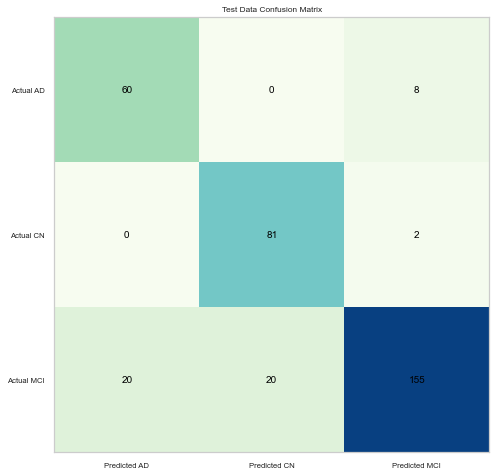

DT
========Model Evaluation Report========
Train Score:  0.6914739884393064
Test Score:  0.7052023121387283
Train BCA: 0.761 | Train AUC: 0.865
Test BCA: 0.760 | Test AUC: 0.855


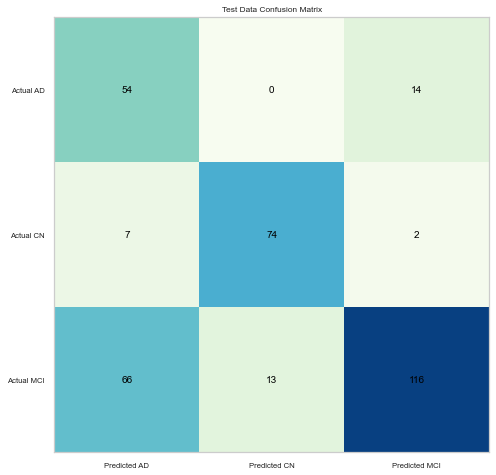

ANN
========Model Evaluation Report========
Train Score:  0.8497109826589595
Test Score:  0.8930635838150289
Train BCA: 0.845 | Train AUC: 0.953
Test BCA: 0.892 | Test AUC: 0.961


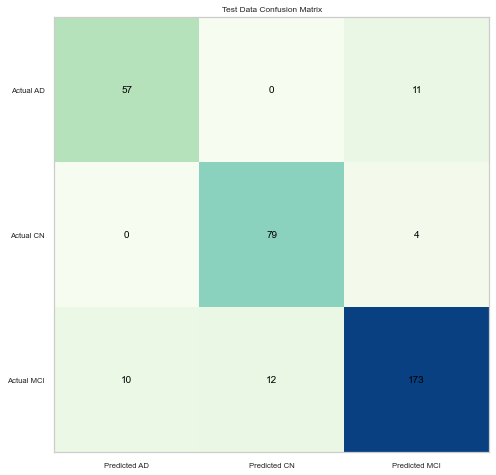

SVM
========Model Evaluation Report========
Train Score:  0.8403179190751445
Test Score:  0.8728323699421965
Train BCA: 0.868 | Train AUC: 0.945
Test BCA: 0.895 | Test AUC: 0.955


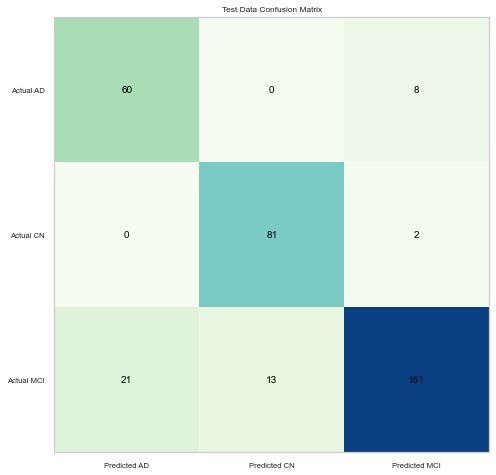

In [13]:
# evaluate
metrics = evaluate(baselearners)

In [14]:
# Best estimator parameter grid
print("LRA:", lra_cv.best_params_)
print("DT:", dtc_cv.best_params_)
print("MLP:", mlp_cv.best_params_)
print("SVM:", svm_cv.best_params_)

LRA: {'C': 78.47599703514607, 'class_weight': 'balanced', 'dual': False, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 1}
DT: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.3, 'splitter': 'best'}
MLP: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'adam'}
SVM: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'linear', 'tol': 0.1}
